In [9]:
import pandas as pd
import numpy as np
import re
import time

import bs4 as bs4
import json

import glob
import tqdm

pd.set_option("max.columns", 131)

#https://strftime.org/
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [10]:
df = pd.read_csv("raw_data.csv", index_col=0)
df = df[df['y'].notnull()]
df.shape

(307, 5)

## 1. Limpeza da data

In [11]:
df_limpo = pd.DataFrame(index=df.index)
df_limpo['title'] = df['title']
df_limpo['date'] = pd.to_datetime(df['upload_date'])

## 2. Limpeza de Views

In [12]:
df_limpo['views'] = df['view_count']

## 3. Features

In [13]:
features = pd.DataFrame(index=df_limpo.index)
y = df['y'].copy()

In [14]:
features['tempo_desde_pub'] = (pd.to_datetime("2019-12-03") - df_limpo['date']) / np.timedelta64(1, 'D')
features['views'] = df_limpo['views']
features['views_por_dia'] = features['views'] / features['tempo_desde_pub']
features = features.drop(['tempo_desde_pub'], axis=1)

In [15]:
features.head()

,views,views_por_dia
0,735081.0,181.232988
1,658147.0,172.109571
2,102757.0,1317.397436
3,6.0,-0.008969
4,3134585.0,2999.602871


<AxesSubplot:>

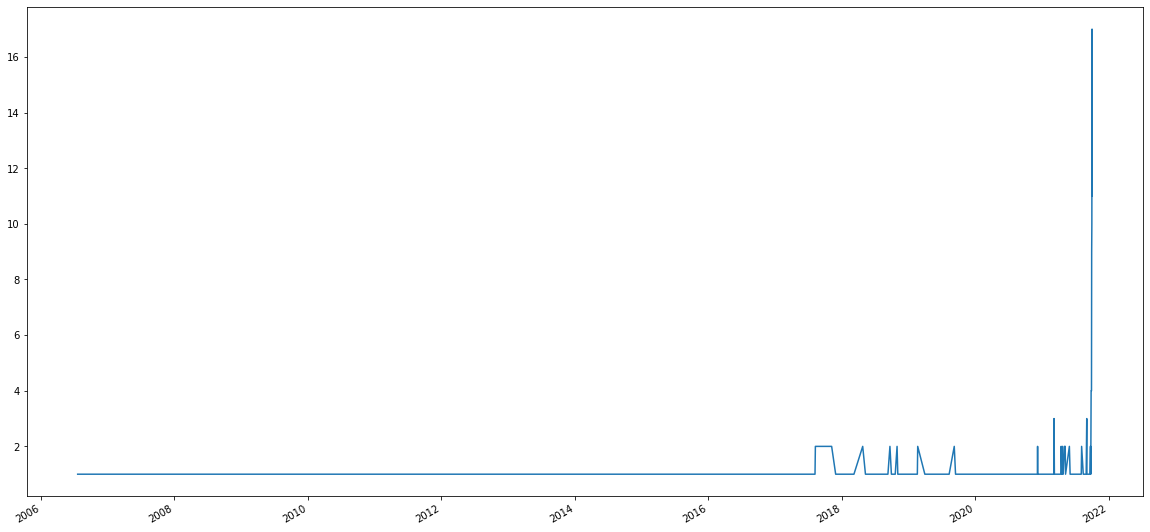

In [16]:
df_limpo['date'].value_counts().plot(figsize=(20,10))

In [17]:
Xtrain, Xval = features[df_limpo['date'] < "2019-04-01"], features[df_limpo['date'] >= "2019-04-01"]
ytrain, yval = y[df_limpo['date'] < "2019-04-01"], y[df_limpo['date'] >= "2019-04-01"]
Xtrain.shape, Xval.shape, ytrain.shape, yval.shape

((121, 2), (186, 2), (121,), (186,))

In [19]:
 from sklearn.tree import DecisionTreeClassifier
mdl = DecisionTreeClassifier(random_state=0, max_depth=2, class_weight="balanced")
mdl.fit(Xtrain, ytrain)

DecisionTreeClassifier(class_weight='balanced', max_depth=2, random_state=0)

In [20]:
p = mdl.predict_proba(Xval)[:, 1]

In [21]:
from sklearn.metrics import roc_auc_score, average_precision_score

In [22]:
average_precision_score(yval, p)

0.22527472527472528

In [23]:
roc_auc_score(yval, p)

0.506896551724138

In [24]:
from sklearn.tree import plot_tree

[Text(279.0, 453.0, 'views <= 7497318.0\ngini = 0.5\nsamples = 121\nvalue = [60.5, 60.5]'),
 Text(139.5, 271.8, 'views <= 3800236.0\ngini = 0.495\nsamples = 103\nvalue = [49.61, 60.5]'),
 Text(69.75, 90.59999999999997, 'gini = 0.497\nsamples = 92\nvalue = [47.19, 40.333]'),
 Text(209.25, 90.59999999999997, 'gini = 0.191\nsamples = 11\nvalue = [2.42, 20.167]'),
 Text(418.5, 271.8, 'views <= 8115324.0\ngini = 0.0\nsamples = 18\nvalue = [10.89, 0.0]'),
 Text(348.75, 90.59999999999997, 'gini = 0.0\nsamples = 1\nvalue = [0.605, 0.0]'),
 Text(488.25, 90.59999999999997, 'gini = 0.0\nsamples = 17\nvalue = [10.285, 0.0]')]

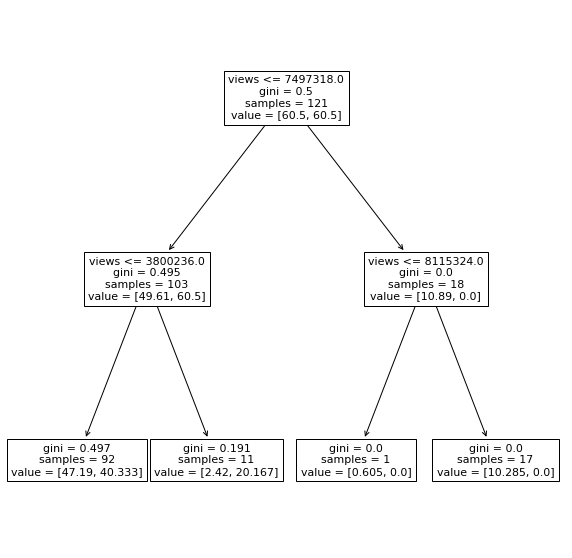

In [25]:
fig, ax = pylab.subplots(1,1, figsize=(10,10))
plot_tree(mdl, ax=ax, feature_names=Xtrain.columns)